In [1]:
import os
import json
import time
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Generate Scalability data

In [2]:
from generate_syn import generate_syn2
generate_syn2('data/scalability.json', n=3000)
with open('data/scalability.json') as f:
    scalability = json.load(f)
num_ts = len(scalability['ts'])

## Run OneShotSTL

In [3]:
results = []
max_online_decompose_num = 500000
for T in [100, 200, 400, 800, 1600, 3200, 6400, 12800]:
    start = time.time()
    cmd = "java -jar java/OneShotSTL/OneShotSTL.jar --method OneShotSTL --task decompose --shiftWindow 0 --period {} --in data/scalability.json --onlyInit".format(T)
    _ = os.system(cmd)
    init_duration = time.time() - start
    start = time.time()
    cmd = "java -jar java/OneShotSTL/OneShotSTL.jar --method OneShotSTL --task decompose --shiftWindow 0 --period {} --in data/scalability.json --maxOnlineDecomposeNum {}".format(T, max_online_decompose_num)    
    _ = os.system(cmd)
    duration = time.time() - start - init_duration
    print(T, init_duration, 1e6 * duration / max_online_decompose_num)
    results.append(['OneShotSTL', T, 1e6 * duration / max_online_decompose_num])

100 2.087401866912842 18.0657958984375
200 1.5100419521331787 16.199336051940918
400 1.7105770111083984 16.075420379638672
800 1.6991267204284668 16.217896461486816
1600 2.031514883041382 17.082744121551514
3200 2.6739931106567383 15.653349876403809
6400 3.5699610710144043 14.538983821868896
12800 5.437496900558472 15.168274402618408


## Run WindowSTL with slidingWindow = 5 * T

In [4]:
max_online_decompose_num = 100
for T in [100, 200, 400, 800, 1600, 3200, 6400, 12800]:
    sliding_window = T * 5
    start = time.time()
    cmd = "java -jar java/OneShotSTL/OneShotSTL.jar --method WindowSTL --task decompose --slidingWindow {} --period {} --in data/scalability.json --onlyInit".format(sliding_window, T)
    _ = os.system(cmd)
    init_duration = time.time() - start
    start = time.time()
    cmd = "java -jar java/OneShotSTL/OneShotSTL.jar --method WindowSTL --task decompose --slidingWindow {} --period {} --in data/scalability.json --maxOnlineDecomposeNum {}".format(sliding_window, T, max_online_decompose_num)    
    _ = os.system(cmd)
    duration = time.time() - start - init_duration
    print(T, init_duration, 1e6 * duration / max_online_decompose_num)
    results.append(['WindowSTL', T, 1e6 * duration / max_online_decompose_num])

100 1.2051279544830322 4816.329479217529
200 1.1654090881347656 9996.898174285889
400 1.2310302257537842 21773.63634109497
800 1.4464991092681885 40095.179080963135
1600 1.2040929794311523 73390.9010887146
3200 1.2692630290985107 155601.9401550293
6400 1.4897680282592773 303902.62842178345
12800 1.4453098773956299 620420.6991195679


## Plot results

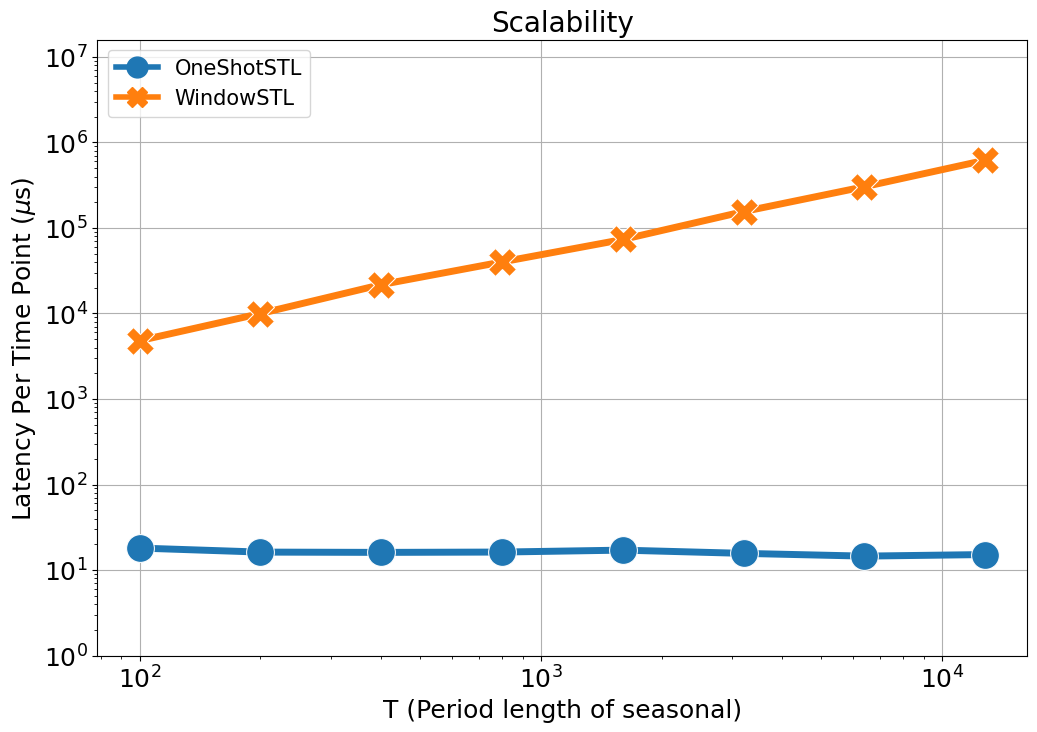

In [5]:
import pandas as pd
import seaborn as sns
result = pd.DataFrame(results, columns=['Method', 'Period', 'Latency'])
result = result.astype({'Period': 'int', 'Latency':'float'})
plt.figure(figsize=(12, 8))
b = sns.lineplot(data=result, x='Period', y='Latency', hue='Method', style='Method', markers=True, linewidth=5, dashes=False, markersize=20)
b.set(xscale='log')
b.set(yscale='log')
b.axes.set_title('Scalability', fontsize=20)
b.set_xlabel('T (Period length of seasonal)', fontsize=18)
# b.set_ylabel("%ss" % r'$ \mu $', fontsize=18)
b.set_ylabel("Latency Per Time Point (%ss)" % r'$ \mu $', fontsize=18)
b.tick_params(labelsize=18)
leg = plt.legend(fontsize=15, loc='upper left')
for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)
    legobj.set_markersize(15)
b.set(ylim=(1, 1.6e7))
plt.grid()